# Lesson 7

In [10]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt
%matplotlib inline

We've learned he basics of linear regression, with one and multiple variables. 

Today we're going to focus on the question of whether one model or set of models is better than another.

We're going to start by going over classical methods, and then talk about methods using cross validation.

# Introduction

Why use classical metrics, like R^2, at all?

Why not just use cross-validation accuracy, since the goal is to make predictions on out-of-sample data?

To understand reason, recall bias-variance:

<img src=http://i.stack.imgur.com/JLDET.png>

**Discussion:** Is linear regression a "high bias" or "high variance" model?

Recall, in the context of regression, what overfitting means:

<img src="https://cloud.githubusercontent.com/assets/846010/11647961/77c2781e-9d3c-11e5-9793-363dab993e14.png">

## Classical metrics for understanding model fit

### R Squared

Formula = (explained variance) / (total variance)

<img src=http://www.rapidinsightinc.com/wordpress/wp-content/uploads/r-squared.png>

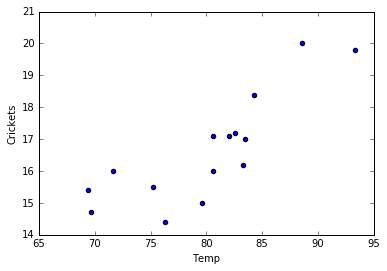

In [2]:
wd = '../../data/'
crickets = pd.read_csv(wd + 'crickets.csv')
# pd.read_csv('../../crickets_temp.csv')
crickets.head()

plt.scatter(crickets.temp, crickets.crickets)
plt.xlabel('Temp')
plt.ylabel('Crickets')

In [11]:
# ## biased fit                                          # ignoring code here
# lm = linear_model.LinearRegression()
# lm.fit(crickets[['crickets']], crickets['temp'])
# lm.score(crickets[['crickets']], crickets['temp'])

0.69746514501673995

### Manual R-Squared Calc

In [9]:
mean_temp = crickets['temp'].mean()         # calc mean
y_diff = crickets['temp'] - mean_temp       # diff from mean
y_diff_squared = y_diff**2                  # squared
total_var = sum(y_diff_squared)             # summed

lm = linear_model.LinearRegression()                 # linear_model imported from scikit learn
lm.fit(crickets[['crickets']],crickets['temp'])      # double brackets needed for the column,  temp is the Y variable

predictions = lm.predict(crickets[['crickets']])      # the yhats, predicted values, using crickets input variableb
pred_diff = crickets['temp'] - predictions            # unexplained variance
pred_diff_squared = pred_diff ** 2
unexplained_var = sum(pred_diff_squared)              # total unexpl variance

print "R-squared: " + str(1 - unexplained_var / total_var), "1 - unexplained variance / total var"

predictions = lm.predict(crickets[['crickets']])
pred_diff = mean_temp - predictions
pred_diff_squared = pred_diff ** 2
explained_var = sum(pred_diff_squared)

print "R-squared: " + str(explained_var / total_var)

R-squared: 0.697465145017 1 - unexplained variance / total var
R-squared: 0.697465145017


In [10]:
lm
lm.score(crickets[['crickets']],crickets['temp'])   # r squared score using the lm object. using x and y variables

0.69746514501673984

### Exercise: (20 minutes)

Another common metric (closely related to R squared) to see how good a regression is is the "mean squared error". Starting from this piece of documentation, calculate mean squared error for this model, both using SKLearn, and manually similar to the method above.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

In [30]:
# manual mean squared error
error = predictions - crickets.temp

error_sq = error**2

mse = sum(error_sq)/len(error_sq)              # 12.70 mean squared error      error_sq.size can also be used
print mse

# sk learn method
print metrics.mean_squared_error(crickets.temp, predictions), "mse"      # 12.70 same as above


# other metrics to see the model "score",      looking at the sk learn metrics API. Regression metrics, clustering metrics
                                                 # AUC Roc curve in the metrics
print metrics.mean_absolute_error(crickets.temp, predictions), "mean abs error"

print metrics.explained_variance_score(crickets.temp, predictions), "metrics expl var score"

12.7031592949
12.7031592949 mse
3.0151084033 mean abs error
0.697465145017 metrics expl var score


In [26]:
error_sq.size

15

# Cross validation

We covered last week how cross validation can prevent overfitting. 

Here's a great illustration of overfitting: http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

Here's a visual reminder of what cross validation is:

<img src='http://blog-test.goldenhelix.com/wp-content/uploads/2015/04/B-fig-1.jpg'>

In [3]:
from sklearn import cross_validation
wd = '../../'                                    # working directory
basketball = pd.read_csv(wd + 'basketball.csv')

In [55]:
basketball.head()            # predict the points per game, using all over variables (usual ML strategy)

#basketball.iloc[0:5, 'weight'] # does not work,   iloc needs index    [0:5, 0]
basketball.loc[0:5, 'weight']                     # loc uses the column name, object

0    225
1    180
2    190
3    180
4    205
5    225
Name: weight, dtype: int64

### Splitting the data up into "X" and "Y"

In [36]:
basketball_x = basketball.loc[:,['height', 'weight', 'pct_fg', 'pct_ft']]   # input, regressors
basketball_y = basketball.loc[:,['ppg']]                                    # predicted var

#### 5 fold cross validation on this dataset

In [37]:
#create a k fold crossval object
kf = cross_validation.KFold(len(basketball), n_folds=5, shuffle=True)  # can add param: random_state=5, to have the same random numbers for each evaluation           
kf

sklearn.cross_validation.KFold(n=54, n_folds=5, shuffle=True, random_state=None)

In [38]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:                          # using linear regression (multivariable)
    # for each fold, for dataset indices in the kf object
    #fit the model on the training data (80% of data randomly selected). ilocate using the train_index
    lm = linear_model.LinearRegression().fit(basketball_x.iloc[train_index], basketball_y.iloc[train_index])
    # mean square error using ytrue and ypredicts,   append to the mse_values array
    mse_values.append(metrics.mean_squared_error(basketball_y.iloc[test_index], lm.predict(basketball_x.iloc[test_index])))
    # rsquared score using lm.score as above
    scores.append(lm.score(basketball_x.loc[test_index], basketball_y.iloc[test_index]))    # score on the test set, not on the entire basketball_x,y set
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)                      # Rsquares are not good, shows with C.V. that the model is not better than random guessing
# the model is not very applicable, the variables may not be linearly related, so the linearity assumption doesnt hold

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 70.2600408282
R2: -0.29291588069
Model 2
MSE: 29.648013263
R2: 0.13388598518
Model 3
MSE: 10.4800416576
R2: -0.18868114039
Model 4
MSE: 57.0282357468
R2: -0.528981654517
Model 5
MSE: 10.9765190681
R2: -2.32985046355
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 35.6785701127
Mean of R2 for all folds: -0.641308630794


In [100]:
lm = linear_model.LinearRegression().fit(basketball_x, basketball_y)
print "~~~~ Single Model ~~~~"
print 'MSE of single model:', metrics.mean_squared_error(basketball_y, lm.predict(basketball_x))
print 'R2: ', lm.score(basketball_x, basketball_y)                     # R2 of single model is not very high

~~~~ Single Model ~~~~
MSE of single model: 26.5654032851
R2:  0.2222506313


## Can we make this model better? (15 minutes)

**Exercise:** Try taking out features, and running the data through the same code as above, and seeing if you can identify any features that are not in fact adding to the likely accuracy of the model on _outside_ data.

In [49]:
# try taking out weight,    still had negative Rsqares     mean Rsq -0.54 (improved a little over all vars)

# take out weight, heigh,    still had negative Rsquares    mean Rsq -0.7

# use only percent field goals       mean Rsq   -0.7
basketball_x = basketball.loc[:,['height','pct_ft','pct_fg']]   # input, regressors
basketball_y = basketball.loc[:,['ppg']] 

mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:                          # using linear regression (multivariable)
    # for each fold, for dataset indices in the kf object
    #fit the model on the training data (80% of data randomly selected). ilocate using the train_index
         #can use another sklearn function here too
    lm = linear_model.LinearRegression().fit(basketball_x.iloc[train_index], basketball_y.iloc[train_index])
    # mean square error using ytrue and ypredicts,   append to the mse_values array
    mse_values.append(metrics.mean_squared_error(basketball_y.iloc[test_index], lm.predict(basketball_x.iloc[test_index])))
    # rsquared score using lm.score as above
    scores.append(lm.score(basketball_x.loc[test_index], basketball_y.iloc[test_index]))    # score on the test set, not on the entire basketball_x,y set
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)      # median could be used too, if we have odd# of folds, so that one bad outcome does not influence the score
print 'Mean of R2 for all folds:', np.mean(scores),                       # Rsquares are not good, shows with C.V. that the model is not better than random guessing
# the model is not very applicable, the variables may not be linearly related, so the linearity assumption doesnt hold

# using only field goal percentage was the best model 
# next, using this, we can lm.fit  using only the pct_fg, and this model would be a better model (Rsq) for future data points


~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 61.3452488688
R2: -0.128867070563
Model 2
MSE: 27.3297162199
R2: 0.201610913043
Model 3
MSE: 10.5170926461
R2: -0.192883586597
Model 4
MSE: 49.6466545678
R2: -0.331074388821
Model 5
MSE: 10.7603354155
R2: -2.26426872208
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 31.9198095436
Mean of R2 for all folds: -0.543096571004


# Regularization

You just "built" several different models - functions that take in data of a particular form and then output predictions about that data - by selecting different variables.

Now, we're going to talk about another way to "build different models" in the context of linear regression - regularization.

## Motivation

When you have many dependent variables, or predictors, trying to predict some outcome, a sign that these variables are overfitting is if the coefficients get extremely big. Regularization makes your model have a "penalty" for having large coefficients.

## Mathematics

Recall that when we form a linear model, we select the model that minimizes the squared error. For a model of the form
$$y_i = f(x_i) + e_i$$
we minimize the sum
$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2}$$
This is an example of a _loss function_, a function that measures the cost of inaccurate model predictions. To apply the technique of regularization, we modify the loss function with a term that penalizes more complex models. For example, we could use a loss function of the form:
$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2 + \alpha \theta_i ^2}$$

or 

The "alpha" term in there represents the "amount of regularization" we apply to our model. The higher alpha, the more we want to "penalize" our model for having large coefficients.

## "Lasso" and "Ridge" regression

Lasso regression applies what is called "L1" regularization to the model parameters, minimizing the cost function:

$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2 + \alpha |\theta_i|}$$

By contrast, "Ridge" regression applies an "L2" regularization to the model parameters, minimizing the cost function:

$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2 + \alpha \theta_i ^2}$$

## Boston dataset example

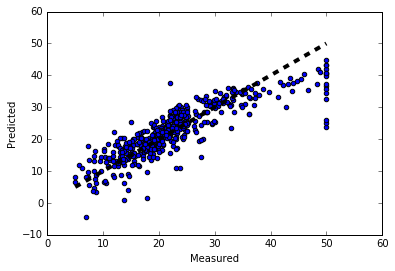

r^2: 0.740607742865


In [14]:
# Work through the cross-validation example, adding in r^2 calculations.
# Does cross-validation produce a better fit in this case? Why or why not?

import pandas as pd

# Without CV

from sklearn import datasets
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn import linear_model
import matplotlib.pyplot as plt

boston = datasets.load_boston()   #sklearn dataset
X = boston.data                # 2x2 array, instead of a dataframe
y = boston.target

lr = linear_model.LinearRegression()
lr.fit(boston.data, y)
predicted_nocv = lr.predict(boston.data)

fig, ax = plt.subplots()
ax.scatter(y, predicted_nocv)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print "r^2:", lr.score(X, y)

(array([  21.,   55.,   82.,  154.,   84.,   41.,   30.,    8.,   10.,   21.]),
 array([  5. ,   9.5,  14. ,  18.5,  23. ,  27.5,  32. ,  36.5,  41. ,
         45.5,  50. ]),
 <a list of 10 Patch objects>)

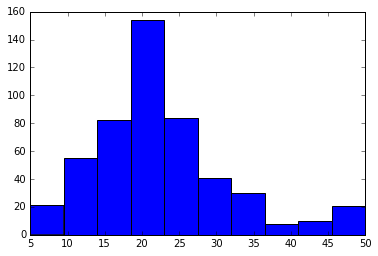

In [5]:
boston.feature_names       # feature names of the boston data
X.shape                              #506 rows
y.shape
plt.hist(y)              # histogram of prices

### R^2 with cross validation

In [15]:
# With CV

lm = linear_model.LinearRegression()

X = pd.DataFrame(boston.data)
y = pd.DataFrame(boston.target)
kf = cross_validation.KFold(len(boston.target), n_folds=5, shuffle=True,random_state=5)
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm.fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X.iloc[test_index], y.iloc[test_index]))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores), "Lin regression with CV"

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 20.9028436804
R2: 0.733020681871
Model 2
MSE: 41.042081016
R2: 0.599320190876
Model 3
MSE: 16.4340472377
R2: 0.7469498642
Model 4
MSE: 25.303963915
R2: 0.707166893694
Model 5
MSE: 21.6536146707
R2: 0.758017546889
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 25.067310104
Mean of R2 for all folds: 0.708895035506 Lin regression with CV


**Explanation:** Linear regression is slightly overfitting.   Rsq of CV is lower than the full data

In [45]:
# With CV

# lm = linear_model.Ridge()              # ridge regression instead of linear regres. alpha=1.0 by default. penalize the coffeficients
# predicted_cv = cross_val_predict(lr, X, y, cv=5)

X = pd.DataFrame(boston.data)
y = pd.DataFrame(boston.target)
kf = cross_validation.KFold(len(boston.target), n_folds=5, shuffle=True,random_state=5)
# print kf
# for train, test in kf:
#     print(test)
    
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.Ridge().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X.iloc[test_index], y.iloc[test_index]))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores), "Ridge Reg with CV"          # Rsquared went down a little from linear reg. (not using random_state)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 21.6305923844
R2: 0.723725589981
Model 2
MSE: 41.5154775917
R2: 0.594698581911
Model 3
MSE: 16.4458894294
R2: 0.746767519086
Model 4
MSE: 24.7248327996
R2: 0.71386895682
Model 5
MSE: 21.725296147
R2: 0.757216495437
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 25.2084176704
Mean of R2 for all folds: 0.707255428647 Ridge Reg with CV


### Ridge regression example of tuning alpha parameter

In [16]:
# Note the "alpha = 0.5" method in     **looks like alpha=1.0 in the .18 version of sklearn

# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

# lm = linear_model.Ridge()
# predicted_cv = cross_val_predict(lr, X, y, cv=5)

X = pd.DataFrame(boston.data)
y = pd.DataFrame(boston.target)
kf = cross_validation.KFold(len(boston.target), n_folds=5, shuffle=True,random_state=5)
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:             #linear regression command
    lm = linear_model.LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X.iloc[test_index], y.iloc[test_index]))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)            #Rsq increased just a little bit with ridge regression

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 20.9028436804
R2: 0.733020681871
Model 2
MSE: 41.042081016
R2: 0.599320190876
Model 3
MSE: 16.4340472377
R2: 0.7469498642
Model 4
MSE: 25.303963915
R2: 0.707166893694
Model 5
MSE: 21.6536146707
R2: 0.758017546889
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 25.067310104
Mean of R2 for all folds: 0.708895035506


### Exercise (20 minutes): Make a plot of the different cross validated scores of this model against different values of alpha to find the optimal alpha  

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

#### To get you started:

Alpha: 1e-10
21.8977792177 MSE Score
Alpha: 1e-09
21.8977792177 MSE Score
Alpha: 1e-08
21.8977792177 MSE Score
Alpha: 1e-07
21.8977792177 MSE Score
Alpha: 1e-06
21.8977792177 MSE Score
Alpha: 1e-05
21.8977792177 MSE Score
Alpha: 0.0001
21.8977792218 MSE Score
Alpha: 0.001
21.8977796241 MSE Score
Alpha: 0.01
21.8978193911 MSE Score
Alpha: 0.1
21.9013688822 MSE Score
Alpha: 1.0
22.0478977951 MSE Score
Alpha: 10.0
22.6655141002 MSE Score
Alpha: 100.0
23.8221486889 MSE Score
Alpha: 1000.0
27.675317375 MSE Score
Alpha: 10000.0
36.7311008026 MSE Score
Alpha: 100000.0
53.5447690249 MSE Score
Alpha: 1000000.0
61.2585977318 MSE Score
Alpha: 10000000.0
66.8672548997 MSE Score
Alpha: 100000000.0
79.3120208723 MSE Score
Alpha: 1000000000.0
83.8022407918 MSE Score
Alpha: 10000000000.0
84.356537364 MSE Score


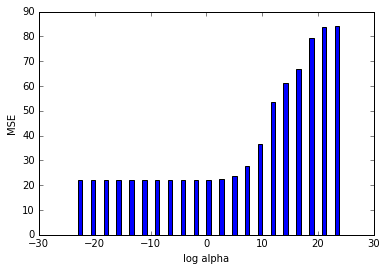

In [54]:
mse = []

alphas = np.logspace(-10, 10, 21)    #logarithmic space 1e-10 ... 1e10
for a in alphas:
    print 'Alpha:', a
    lm = linear_model.Ridge(alpha=a)
    lm.fit(X, y)
#     print lm.coef_
    print metrics.mean_squared_error(y, lm.predict(X)), "MSE Score"
    mse.append(metrics.mean_squared_error(y, lm.predict(X)))
    


plt.bar(np.log(alphas),mse)
plt.xlabel("log alpha"); plt.ylabel("MSE")          # two commands separated by a ";"
# plt.bar(alphas,mse,log=True)       #logarithm of y values, not x



Alpha: 1e-10
Mean MSE for fold alpha:  1e-10 37.2228436366
Alpha: 1e-09
Mean MSE for fold alpha:  1e-09 37.2228436322
Alpha: 1e-08
Mean MSE for fold alpha:  1e-08 37.2228435873
Alpha: 1e-07
Mean MSE for fold alpha:  1e-07 37.2228431385
Alpha: 1e-06
Mean MSE for fold alpha:  1e-06 37.2228386511
Alpha: 1e-05
Mean MSE for fold alpha:  1e-05 37.2227937779
Alpha: 0.0001
Mean MSE for fold alpha:  0.0001 37.2223451187
Alpha: 0.001
Mean MSE for fold alpha:  0.001 37.2178658046
Alpha: 0.01
Mean MSE for fold alpha:  0.01 37.173789125
Alpha: 0.1
Mean MSE for fold alpha:  0.1 36.7947970695
Alpha: 1.0
Mean MSE for fold alpha:  1.0 35.3440684502
Alpha: 10.0
Mean MSE for fold alpha:  10.0 33.4578582421
Alpha: 100.0
Mean MSE for fold alpha:  100.0 29.9250795432
Alpha: 1000.0
Mean MSE for fold alpha:  1000.0 32.8203844751
Alpha: 10000.0
Mean MSE for fold alpha:  10000.0 44.5600682805
Alpha: 100000.0
Mean MSE for fold alpha:  100000.0 61.1800030549
Alpha: 1000000.0
Mean MSE for fold alpha:  1000000.0 68

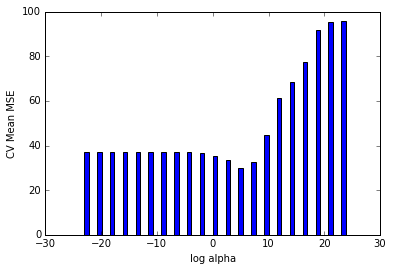

In [119]:
#### cross validation                            # shuffle data before splitting into braches. split into5 subsets once
                                                 # with shuffle on, can some datapoints be repeated in test subsets?no.
                                                # shuffle off splits the data and no points are repeated in the test set
kf = cross_validation.KFold(len(boston.target), n_folds=5)  #shuffle=True,random_state=5
mse_cv_values = []    #store the mean mse (from CV) for each alpha


alphas = np.logspace(-10, 10, 21)    #logarithmic space 1e-10 ... 1e10
for a in alphas:
    print 'Alpha:', a
    mse = []              # store the mses from each CV
    
    # cross validation
    for train_index, test_index in kf:             #linear regression command
#         print test_index
        lm = linear_model.Ridge(alpha=a).fit(X.iloc[train_index], y.iloc[train_index])
        mse.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))

    print "Mean MSE for fold alpha: ", a, np.mean(mse)
    mse_cv_values.append(np.mean(mse))
#end alphas loop    


plt.bar(np.log(alphas),mse_cv_values)
plt.xlabel("log alpha"); plt.ylabel("CV Mean MSE")

# with shuffle=false the minimizing alpha =1000

### Or we can use grid search to make this faster

In [78]:
from sklearn import grid_search
                         # http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
alphas = np.logspace(-10, 10, 21)       # exponential alphas,     grid search alphas with CV (default folds=3)
gs = grid_search.GridSearchCV(
    cv=5,
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(X, y)                         #cv default =3,   also tried cv=5.  Shuffle=False by default here


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

##### Best score 

In [79]:
print gs.best_score_       #didnt match the best score of the manual for-loop above (with cv didnt match either)
                           # could be that the random state was different for this 5fold grid search

-29.8913056974


##### mean squared error here comes in negative, so let's make it positive.

In [80]:
print -gs.best_score_ 

29.8913056974


In [112]:
# plt.bar(np.log(alphas),gs.grid_scores_)    #grid scores list of mean, std, alpha param. plt didt work

# type(gs.grid_scores_   #list

##### explains which grid_search setup worked best

In [81]:
print gs.best_estimator_    #optimizing value    (alpha = 100 best estimator)

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


##### shows all the grid pairings and their performances.

In [77]:
print gs.grid_scores_  # shape of the MSE was different than above CV with shuffle on.
                       #for grid search MSE scores decreased then increased, with a min in the middle 
                  
                       # with shuffle=false, a similar curve for MSE resulted. and the minimizer was similar (1000)


[mean: -37.17395, std: 23.09935, params: {'alpha': 1e-10}, mean: -37.17395, std: 23.09935, params: {'alpha': 1.0000000000000001e-09}, mean: -37.17395, std: 23.09935, params: {'alpha': 1e-08}, mean: -37.17395, std: 23.09936, params: {'alpha': 9.9999999999999995e-08}, mean: -37.17394, std: 23.09936, params: {'alpha': 9.9999999999999995e-07}, mean: -37.17390, std: 23.09937, params: {'alpha': 1.0000000000000001e-05}, mean: -37.17345, std: 23.09951, params: {'alpha': 0.0001}, mean: -37.16897, std: 23.10090, params: {'alpha': 0.001}, mean: -37.12496, std: 23.11456, params: {'alpha': 0.01}, mean: -36.74647, std: 23.22926, params: {'alpha': 0.10000000000000001}, mean: -35.29740, std: 23.51801, params: {'alpha': 1.0}, mean: -33.41434, std: 21.53171, params: {'alpha': 10.0}, mean: -29.89131, std: 13.42948, params: {'alpha': 100.0}, mean: -32.78886, std: 13.62586, params: {'alpha': 1000.0}, mean: -44.52616, std: 22.30288, params: {'alpha': 10000.0}, mean: -61.13753, std: 29.88650, params: {'alpha

In [120]:
# gs.cv_results_         # attribute in 0.18 version of sk learn

## Mini-Project (rest of class / first 30-60 minutes of next class)

In [150]:
wd = '../../data/'
salary = pd.read_csv(wd + 'salary.csv')
salary.head()

,sx,rk,yr,dg,yd,sl
0,male,full,25,doctorate,35,36350
1,male,full,13,doctorate,22,35350
2,male,full,10,doctorate,23,28200
3,female,full,7,doctorate,27,26775
4,male,full,19,masters,30,33696
